In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [77]:
OD=np.load('OD.npy').astype('int')

C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


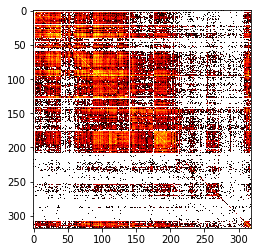

In [78]:
plt.imshow(np.log10(OD/sum(sum(OD))), cmap='hot', interpolation='nearest')
plt.show()

In [79]:
Friction=np.load('friction.npy')

In [80]:
def CalcSinglyConstrained(ProdA, AttrA, F):
    '''Calculates singly constrained trip distribution for a given friction factor matrix
    ProdA = Production array
    AttrA = Attraction array
    F = Friction factor matrix
    Resutrns trip table
    '''
    SumAjFij = (AttrA*F).sum(1)
    SumAjFij[SumAjFij==0]=0.0001
    return ProdA*(AttrA*F).transpose()/SumAjFij

def PPMCGM(OD,Friction,eps):
    Pro=np.sum(OD, axis=0)+eps
    Att=Attadj=np.sum(OD, axis=1)+eps
    F=Friction+eps
    predictedOD=CalcSinglyConstrained(Pro, Att, F)
    MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    
    for i in range(10):
        Pro=np.sum(predictedOD, axis=0)+eps
        Att=np.sum(predictedOD, axis=1)+eps
        Attadj=Attadj*(np.sum(OD, axis=1)/Att)
        predictedOD=CalcSinglyConstrained(Pro, Attadj, F)
        MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    print (MAE)
    return predictedOD.astype('int')

In [81]:
eps=1e-5

In [82]:
predictedOD=PPMCGM(OD,Friction,eps)

3.379601630942651


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


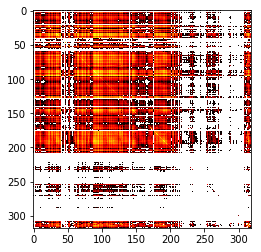

In [83]:
plt.imshow(np.log10(predictedOD/sum(sum(predictedOD))), cmap='hot', interpolation='nearest')
plt.show()

baseline models

In [297]:
def GravExp(dij,mi,mj,beta,OD):
    n=len(dij)
    predictedOD=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if i!=j:
                predictedOD[i][j]=mi[i]*mj[j]*np.exp(dij[i][j]*(-beta))
    MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    print (MAE)
    return predictedOD.astype('int64')

In [298]:
mi=np.sum(OD, axis=0)
mj=Attadj=np.sum(OD, axis=1)

In [299]:
dij=np.loadtxt('distance.txt')

In [300]:
predictedOD=GravExp(dij,mi,mj,0.01,OD)

2585746.5615306986


In [174]:
def UM(predictedOD,Oi):
    n=len(Oi)
    nbCommuters =0
    for i in range(n):
        nbCommuters +=Oi[i]

    sumt=0
    for i in range(n):
        for j in range(n):
            sumt+=predictedOD[i][j]
            
    sumi=np.zeros(n)
    for i in range(n):
        for j in range(n):
            sumi[i]+=predictedOD[i][j]
            
            
    nb=0
    predictedOD_constrained=np.array([[0]*n]*n)
    for i in range(n):
        if sumi[i]>0:
            for j in range(n):
                predictedOD_constrained[i][j]=np.floor(nbCommuters*predictedOD[i][j]/sumt)
                nb+=predictedOD_constrained[i][j]
    idx=Multinomial_ij(nbCommuters-nb.astype('int'),predictedOD,sumi)
    
    for k in idx:
        predictedOD_constrained[k[0]][k[1]]+=1
    
    return predictedOD_constrained

In [340]:
def Multinomial_ij(n, weights, s):
    randomIdx=np.array([[0]*2]*n).astype('int64')
    sumt=0
    
    for k in range(len(s)):
        sumt+=s[k]
    random=np.array([0]*n).astype('float64')
    randomi=np.array([0]*n).astype('float64')
    for k in range(n):
        for i in range(len(weights)):
            random[k]=np.random.random()*sumt
            randomi[k]=random[k]
    
    for k in range(n):
        for i in range(len(s)):
            randomi[k]-=s[i]
            random[k]-=s[i]
            if randomi[k]<=0:
                random[k]+=s[i]
                randomIdx[k][0]=i
                break
                
    for j in range(len(weights)):
        random[k]-=weights[randomIdx[k][0]][j]
        if random[k]<=0:
            randomIdx[k][1]=j
            break

    return randomIdx

In [172]:
predictedOD_constrained=UM(predictedOD,mi)

34111


In [173]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.904018828369131


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


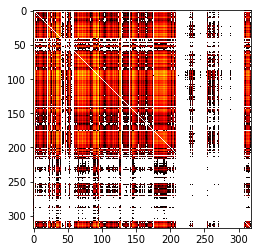

In [167]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [221]:
def PCM(predictedOD,Oi):
    n=len(Oi)
    predictedOD_constrained=np.array([[0]*n]*n)
    sumi=np.array([0]*n).astype('int64')
    for i in range(n):
        for j in range(n):
            sumi[i]+=predictedOD[i][j]
            
    nb=np.array([0]*n)
    for i in range(n):
        if sumi[i]>0:
            for j in range(n):
                predictedOD_constrained[i][j]=np.floor(Oi[i]*predictedOD[i][j]/sumi[i])
                nb[i]+=predictedOD_constrained[i][j]
    
    for i in range(n):
        if Oi[i]!=0:
            idx=Multinomial_i(Oi[i]-nb[i],predictedOD[i],sumi[i])
            for k in idx:
                predictedOD_constrained[i][k]+=1
    
    return predictedOD_constrained

In [234]:
def Multinomial_i(n,weights,s):
    randomIdx=np.array([0]*n)
    random=np.array([0]*n).astype('int64')
    for k in range(n):
        random[k]=np.random.random()*s
        
    for k in range(n):
        for i in range(len(weights)):
            random[k]-=weights[i]
            if random[k]<=0:
                randomIdx[k]=i
                break
    return randomIdx

In [235]:
predictedOD_constrained=PCM(predictedOD,mi)

In [237]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.753629207705392


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


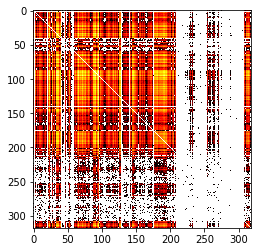

In [238]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [251]:
def ACM(predictedOD,Dj):
    n=len(Dj)
    predictedOD_constrained=np.array([[0]*n]*n).astype('int64')
    tweights=np.array([[0]*n]*n).astype('int64')
    for i in range(n):
        for j in range(n):
            tweights[i][j]=predictedOD[j][i]
            
    sumi=np.array([0]*n).astype('int64')
    for i in range(n):
        for j in range(n):
            sumi[i]+=tweights[i][j]
            
    nb=np.array([0]*n).astype('int64')
    for i in range(n):
        if sumi[i]>0:
            for j in range(n):
                predictedOD_constrained[i][j]=np.floor(Dj[i]*tweights[i][j]/sumi[i])
                nb[i]+=predictedOD_constrained[i][j]
    
    for i in range(n):
        if Dj[i]!=0:
            idx=Multinomial_i(Dj[i]-nb[i],tweights[i],sumi[i])
            for k in idx:
                predictedOD_constrained[k][i]+=1
    
    return predictedOD_constrained

In [252]:
predictedOD_constrained=ACM(predictedOD,mj)

In [253]:
predictedOD_constrained

array([[ 0, 16,  0, ...,  7,  1,  2],
       [11,  0,  0, ..., 12,  1,  6],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 5, 13,  0, ...,  0,  1,  2],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  2,  0, ...,  2,  0,  0]], dtype=int64)

In [254]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

3.311281199319647


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


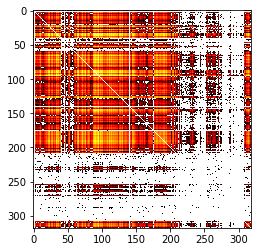

In [255]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [284]:
def DCM(predictedOD,Oi,Dj,maxIter, closure):
    n=len(Oi)
    marg = np.array([[0]*2]*n).astype('float64')
    for i in range(n):
        marg[i][0] = Oi[i]
        marg[i][1] = Dj[i]
        if marg[i][0] == 0:
            marg[i][0] = 0.01
        if marg[i][1] == 0:
            marg[i][1] = 0.01
            
    weights = np.array([[0]*n]*n).astype('float64')
    for i in range(n):
        for j in range(n):
            weights[i][j] = predictedOD[i][j]
            if weights[i][j] == 0:
                weights[i][j] = 0.01
    iter =0
    critOut=1
    critIn=1
    sout=np.array([0]*n).astype('float64')
    sin=np.array([0]*n).astype('float64')
    
    while ((critOut > closure or critIn > closure) and (iter <= maxIter)):
        for i in range(n):
            sout[i]=0
            for k in range(n):
                sout[i]+=weights[i][k]
        for i in range(n):
            for j in range(n):
                weights[i][j] = marg[i][0] * weights[i][j] / sout[i]
        for i in range(n):
            sin[i]=0
            for k in range(n):
                sin[i]+=weights[k][i]
        for i in range(n):
            for j in range(n):
                weights[i][j] =marg[j][1] * weights[i][j] / sin[j]
        critOut = 0
        critIn = 0
        for i in range(n):
            sout[i]=0
            sin[i]=0
            for k in range(n):
                sout[i] += weights[i][k]
                sin[i] += weights[k][i]
            critOut = max(critOut, abs(1 - (sout[i] / marg[i][0])))
            critIn = max(critIn, abs(1 - (sin[i] / marg[i][1])))
        iter+=1
    predictedOD_constrained=UM(weights,Oi)
    return predictedOD_constrained

In [285]:
predictedOD_constrained=DCM(predictedOD,mi,mj,10,0.1)

In [286]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.900142399430402


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


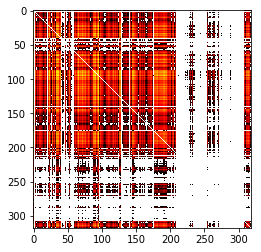

In [287]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [310]:
predictedOD=NGravExp(dij,mi,mj,0.01,OD)

1568.5284502195325


In [309]:
def NGravExp(dij,mi,mj,beta,OD):
    n=len(dij)
    predictedOD=np.array([[0]*n]*n)
    for i in range(n):
        for j in range(n):
            if i!=j:
                predictedOD[i][j]=mj[j]*np.exp(dij[i][j]*(-beta))
    MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    print (MAE)
    return predictedOD.astype('int64')

In [316]:
predictedOD_constrained=UM(predictedOD,mi)

In [317]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

6.446995767572485


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


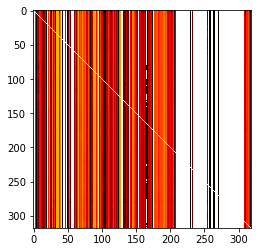

In [318]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [319]:
predictedOD_constrained=PCM(predictedOD,mi)

In [320]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.752600767374708


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


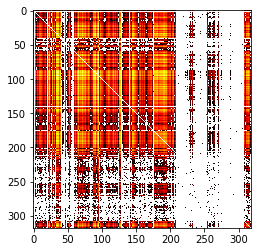

In [321]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [326]:
predictedOD_constrained=ACM(predictedOD,mj)

In [327]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

5.30503144654088


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


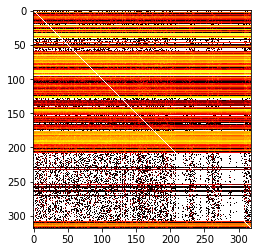

In [328]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [329]:
predictedOD_constrained=DCM(predictedOD,mi,mj,10,0.1)

In [330]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.900320398718405


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


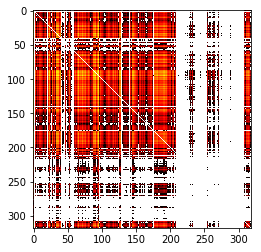

In [331]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [336]:
def GravPow(dij,mi,mj,beta,OD):
    n=len(dij)
    predictedOD=np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if i!=j:
                predictedOD[i][j]=mi[i]*mj[j]*np.power(dij[i][j],(-beta))
    MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    print (MAE)
    return predictedOD.astype('int64')

In [337]:
predictedOD=GravPow(dij,mi,mj,0.01,OD)

2628460.589585581


In [341]:
predictedOD_constrained=UM(predictedOD,mi)

In [342]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.914421897867964


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


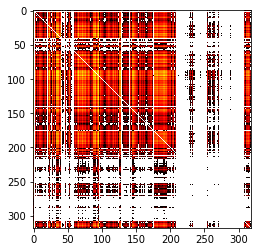

In [343]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [344]:
predictedOD_constrained=PCM(predictedOD,mi)

In [345]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.7595031842094855


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


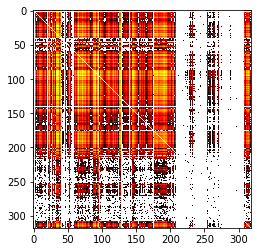

In [346]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [347]:
predictedOD_constrained=ACM(predictedOD,mj)

In [348]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

3.324413591234524


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


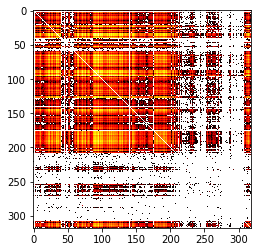

In [349]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [350]:
predictedOD_constrained=DCM(predictedOD,mi,mj,10,0.1)

In [351]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.908706142953206


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


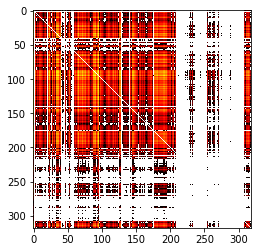

In [352]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [355]:
def NGravPow(dij,mi,mj,beta,OD):
    n=len(dij)
    predictedOD=np.array([[0]*n]*n)
    for i in range(n):
        for j in range(n):
            if i!=j:
                predictedOD[i][j]=mj[j]*np.power(dij[i][j],(-beta))
    MAE=np.mean(abs(np.array(predictedOD)-np.array(OD)))
    print (MAE)
    return predictedOD.astype('int64')

In [356]:
predictedOD=GravPow(dij,mi,mj,0.01,OD)

2628460.589585581


In [357]:
predictedOD_constrained=UM(predictedOD,mi)

In [358]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.914421897867964


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


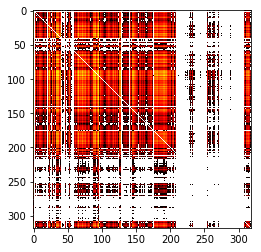

In [359]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [360]:
predictedOD_constrained=PCM(predictedOD,mi)

In [361]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.763399390846881


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


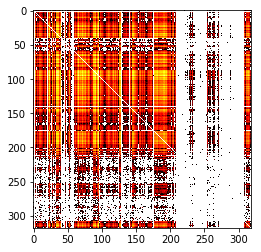

In [362]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [366]:
predictedOD_constrained=ACM(predictedOD,mj)

In [367]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

3.3258178078398797


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


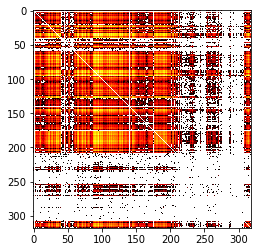

In [368]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()

In [369]:
predictedOD_constrained=DCM(predictedOD,mi,mj,10,0.1)

In [370]:
MAE=np.mean(abs(np.array(predictedOD_constrained)-np.array(OD)))
print (MAE)

4.908706142953206


C:\ProgramData\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


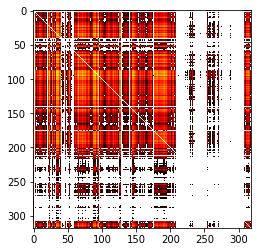

In [371]:
plt.imshow(np.log10(predictedOD_constrained/sum(sum(predictedOD_constrained))), cmap='hot', interpolation='nearest')
plt.show()